# Are graph embeddings continuous? (Embedding by graph kernels)

Graph kernels provide a way to embed a whole graph into a vector feature space. Many kernels can be used, but they all share the same principle: to count elementary sub-structures of a graph.

Using chains and cycles, we give an example of two graph kernels, shortest path and 3-graphlet, the latter being somewhat "discontinuous". 

Defining the exact meaning of "discontinuous" is not a trivial matter since graph kernels are by essence discrete (they are counting the number of occurences of sub-structures), so their resulting embeddings do not extend naturally to the notion of small perturbation of the graph weights as we do in DeepWalk or Eigenmap. Instead, we compute the $L^1$ Wasserstein metric between the embbeding vector of the chain and the cycle and show that some kernels result in large distances.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import wasserstein_distance

from graph_embedding_continuity import *

In [2]:
# number of nodes for each graph type
N = 30

In [3]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G = nx.union(G1, G2)

G.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph by removing the bridge edge, resulting in a disconnected graph
G_removed = deepcopy(G)
G_removed.remove_edge(N-1, N)

In [4]:
# shortest path kernel
emb_sp = graph_kernel_embedding([G], k=0, kernel='shortest_path')
emb_sp_removed = graph_kernel_embedding([G_removed], k=0, kernel='shortest_path')

# graphlet kernel
config_graphlet = {'k': 3, 'n_samples' : 400}
emb_g = graph_kernel_embedding([G], k=0, kernel='graphlet', config=config_graphlet)
emb_g_removed = graph_kernel_embedding([G_removed], k=0, kernel='graphlet', config=config_graphlet)

# normalization
emb_sp /= emb_sp.sum()
emb_sp_removed /= emb_sp_removed.sum()

emb_g /= emb_g.sum()
emb_g_removed /= emb_g_removed.sum()

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


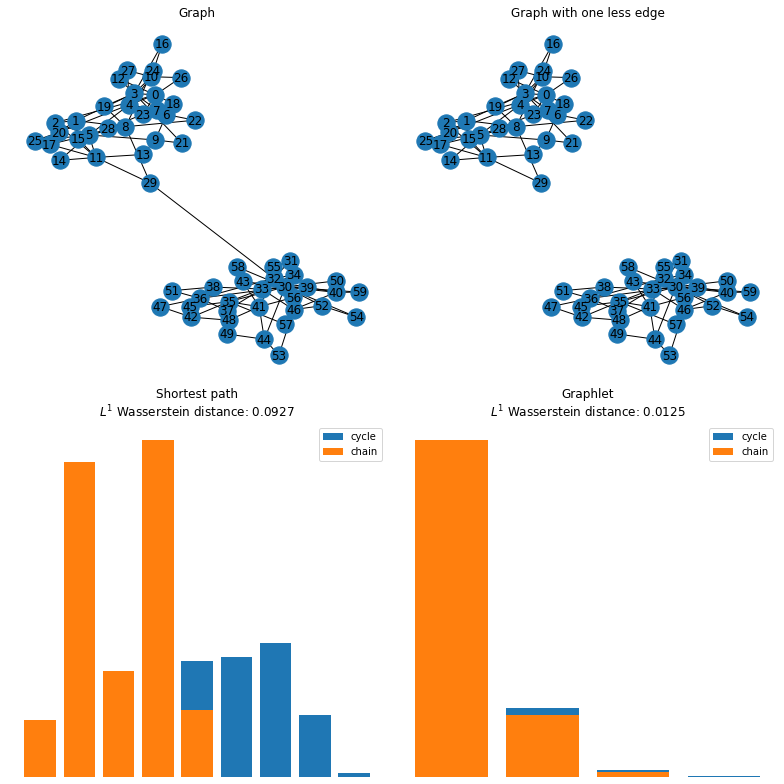

In [5]:
fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=2)

wass_sp = wasserstein_distance(emb_sp, emb_sp_removed)
wass_g = wasserstein_distance(emb_g, emb_g_removed)

ax = axes[0, 0]
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')
    
ax = axes[0, 1]
nx.draw_networkx(G_removed, pos=pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[1, 0]
ax.bar(range(1, len(emb_sp)+1), emb_sp, label='cycle')
ax.bar(range(1, len(emb_sp_removed)+1), emb_sp_removed, label='chain')
ax.set_title('Shortest path\n$L^1$ Wasserstein distance: {:.4f}'.format(wass_sp))
ax.legend(loc='upper right')
ax.axis('off')

ax = axes[1, 1]
ax.bar(range(1, len(emb_g)+1), emb_g, label='cycle')
ax.bar(range(1, len(emb_g_removed)+1), emb_g_removed, label='chain')
ax.set_title('Graphlet\n$L^1$ Wasserstein distance: {:.4f}'.format(wass_g))
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('graph_kernels_bridge_removal.eps')